# Objective
This study is a comparative exploration of dense neural networks and convolutional neural networks (CNNs) for image classification, with a two-fold goal: develop a neural network model for highly-accurate and generalizable  classification and gain an in-depth understanding of how various factors affect fitting and ultimate test set performance with networks of differing topologies and hyperparameter settings. 

The experiments below will help determine different deep learning models' potential utility in classification problems for computer vision on the Fashion MNIST dataset of Zalando's article images and for future analogous image recognition problems, for example facial recognition.

# Experimental overview
This final experiment is run to evaluate and compare various network topologies and hyperparameter settings, assessing their potential impact on model performance (loss and accuracy) and process time, all with dropout applied:

* EXPERIMENT 1: DNN with 2 layers (no drop out)

* EXPERIMENT 2: DNN with 3 layers (no drop out)

* EXPERIMENT 3: CNN with 2 convolution/max pooling layers (no drop out)

* EXPERIMENT 4: CNN with 3 convolution/max pooling layers (no drop out)

* **EXPERIMENT 5: Re-run all experiments 1-4 with 20 percent dropout regularization to gauge its effectiveness in addressing issues with variance**

In each experiment, certain parameters are held constant for comparison:
* Batch size = 100
* Epochs = 20
* Loss function = sparse categorical cross-entropy
* Optimizer = Adam

## Setup and dependencies

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import os
from collections import Counter
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Check Keras version
keras.__version__

'2.3.0-tf'

In [0]:
# Check tensorflow version
tf.__version__

'2.2.0-rc4'

In [0]:
# Set seed for consistency of results
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Saving in Colab
os.getcwd()
%cd /content/gdrive/My\ Drive/MSDS458/weekfive
!pwd
!ls
print('Working Directory')
print(os.getcwd())
work_dir = "content/gdrive/My Drive/MSDS458/weekfive"
# chp_id = "ann"

/content/gdrive/My Drive/MSDS458/weekfive
/content/gdrive/My Drive/MSDS458/weekfive
figures  model.png  results
Working Directory
/content/gdrive/My Drive/MSDS458/weekfive


## Import dataset: Fashion MNIST
Zalando is Europe's leading online fashion platform for women, men and children. `Fashion-MNIST` is a dataset of their product images. Just like the `MNIST` dataset, the `Fashion-MNIST` also consists of 70,000 grayscale images of 28x28 pixels divided into 60,000 training images and 10,000 test images. 

Each image is labeled with with an integer from 0 to 9 representing 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', respectively. 

`Fashion-MNIST` is intended to serve as a direct drop-in replacement for the original `MNIST` dataset for benchmarking machine learning algorithms since the the original `MNIST` was found to be too easy for the current machine learning models. In particular, Fashion-Mist shares the same image size and structure of training and testing splits as `MNIST`. Also like `MNIST` it comes prepackaged in `tf.Keras`. We use:

```python
fashion_mnist.load_data()
```
which provides datasets (and the corresponding labels) as Numpy arrays. See the `Fashion-MNIST` GitHub page for a lot more information about the data sets and benchmarks for 129 classifiers trained on the data:

https://github.com/zalandoresearch/fashion-mnist

In [4]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

## Data pre-processing
Before training, data is reshaped into the shape that the network expects and scaled so that all values are in the \[0, 1] interval.

Training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

Training data is then transformed a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [0]:
# We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1. 

train_images = train_images.reshape((60000, 28 * 28)) 
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))  
test_images = test_images.astype('float32') / 255

## Train/test/validation split
70,000 images are divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [0]:
# Create validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Create a callback to get training times and test evaluation times

In [0]:
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

# EXPERIMENT  1:

The baseline `DNN` model will consist of 784 input nodes, a hidden layer with 5 nodes and 10 output nodes (corresponding to the 10 fashion categories).

## Build the network

Here the network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

The first `Dense` layer, the hidden layer, consists of 5 nodes.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of 10 classes.

In [0]:
model_1do = models.Sequential()
# model_1do.add(layers.Flatten(input_shape=[28, 28]))
model_1do.add(layers.Dense(5, activation='relu', input_shape=(28 * 28,)))
model_1do.add(layers.Dropout(0.2))
model_1do.add(layers.Dense(10, activation='softmax')) 

In [0]:
model_1do.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 3925      
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


## Compile the model

To make our network ready for training, the compilation step consists of the following:

* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* Metrics to monitor during training and testing. We will use accuracy in this case (the fraction of the images that were correctly classified).

In [0]:
model_1do.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [11]:
train_rt = TrainRuntimeCallback()
history = model_1do.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size=100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_1do.h5'
model_path = os.path.join(save_dir, model_name)
model_1do.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 1s 2ms/step - loss: 1.7769 - accuracy: 0.3775 - val_loss: 1.3391 - val_accuracy: 0.6054
Epoch 2/20
550/550 [==============================] - 1s 2ms/step - loss: 1.4485 - accuracy: 0.5049 - val_loss: 1.1016 - val_accuracy: 0.7096
Epoch 3/20
550/550 [==============================] - 1s 2ms/step - loss: 1.3306 - accuracy: 0.5450 - val_loss: 0.9546 - val_accuracy: 0.7346
Epoch 4/20
550/550 [==============================] - 1s 2ms/step - loss: 1.1655 - accuracy: 0.5791 - val_loss: 0.7832 - val_accuracy: 0.7732
Epoch 5/20
550/550 [==============================] - 1s 2ms/step - loss: 1.1245 - accuracy: 0.5967 - val_loss: 0.7352 - val_accuracy: 0.7864
Epoch 6/20
550/550 [==============================] - 1s 2ms/step - loss: 1.1018 - accuracy: 0.6018 - val_loss: 0.7309 - val_accuracy: 0.7956
Epoch 7/20
550/550 [==============================] - 1s 2ms/step - loss: 1.0776 - accuracy: 0.6146 - val_loss: 0.7166 - val_accuracy: 0.7944
Epoch 

In [12]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

25.842328

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [13]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_1do.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.7166 - accuracy: 0.7905


In [14]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.654728

## Create a DataFrame for the training and test statistics

We will create a pandas DataFrame to hold the training/test times and their accuracy and loss values of each of the four models (and their variations) that we will consider in these experiment. Statistics from all subsequent models are added to the DataFrame.

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,1.049302,0.623764,0.695265,0.8054
16,1.040097,0.628236,0.694121,0.8028
17,1.047677,0.624073,0.700288,0.8016
18,1.039166,0.627400,0.690486,0.8092
19,1.039818,0.627073,0.687543,0.8116


In [17]:
# Create a results DataFrame using the last row of history_df
results_df_do = history_df.iloc[-1:].copy()
results_df_do.insert(0,'model','DNN (2 layers DO)') # went the model name to appear first
results_df_do['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df_do['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df_do

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (2 layers DO),1.039818,0.627073,0.687543,0.8116,25.842328,0.654728


## Plot the performance 

**Figure 1: Learning curves for Model 1 with dropout**

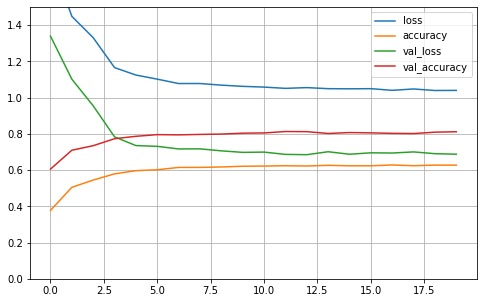

In [18]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1_do", tight_layout=False)
plt.show()

# EXPERIMENT  2:

This time our `DNN` model will consist of 784 input nodes, a hidden layer with `10 nodes`, another hidden layer with `5 nodes` and 10 output nodes (corresponding to the 10 fashion categories).

In [0]:
model_2do = models.Sequential()
# model_1do.add(layers.Flatten(input_shape=[28, 28]))
model_2do.add(layers.Dense(5, activation='relu', input_shape=(28 * 28,)))
model_2do.add(layers.Dropout(0.2))
model_2do.add(layers.Dense(10, activation='relu'))
model_2do.add(layers.Dropout(0.2))
model_2do.add(layers.Dense(10, activation='softmax')) 

In [0]:
model_2do.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 3925      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                60        
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
Total params: 4,095
Trainable params: 4,095
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [0]:
model_2do.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [21]:
train_rt = TrainRuntimeCallback()
history = model_2do.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_2do.h5'
model_path = os.path.join(save_dir, model_name)
model_2do.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 1s 2ms/step - loss: 1.7174 - accuracy: 0.3207 - val_loss: 1.0735 - val_accuracy: 0.6256
Epoch 2/20
550/550 [==============================] - 1s 2ms/step - loss: 1.2727 - accuracy: 0.4795 - val_loss: 0.8246 - val_accuracy: 0.7064
Epoch 3/20
550/550 [==============================] - 1s 2ms/step - loss: 1.1548 - accuracy: 0.5303 - val_loss: 0.7642 - val_accuracy: 0.7216
Epoch 4/20
550/550 [==============================] - 1s 2ms/step - loss: 1.0936 - accuracy: 0.5581 - val_loss: 0.7498 - val_accuracy: 0.7328
Epoch 5/20
550/550 [==============================] - 1s 2ms/step - loss: 1.0621 - accuracy: 0.5730 - val_loss: 0.7051 - val_accuracy: 0.7522
Epoch 6/20
550/550 [==============================] - 1s 2ms/step - loss: 1.0433 - accuracy: 0.5759 - val_loss: 0.7190 - val_accuracy: 0.7368
Epoch 7/20
550/550 [==============================] - 1s 2ms/step - loss: 1.0336 - accuracy: 0.5820 - val_loss: 0.7151 - val_accuracy: 0.7430
Epoch 

In [22]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

25.392829

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [23]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_2do.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.6852 - accuracy: 0.7489


In [24]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.637817

## Add the statistics to the results DataFrame

We add the performance statistics for the new model to our DataFrame using history.

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.985214,0.601491,0.702150,0.7470
16,0.987401,0.602982,0.692740,0.7476
17,0.981465,0.607400,0.680032,0.7568
18,0.976749,0.607200,0.672104,0.7674
19,0.979232,0.608491,0.672728,0.7602


In [27]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','DNN (3 layers DO)') # went the model name to appear first
results_df2['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df2['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df2

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (3 layers DO),0.979232,0.608491,0.672728,0.7602,25.392829,0.637817


In [0]:
# # Add the new data to results_df
# results_df=results_df.append(results_df2,ignore_index=True)
# results_df

## Save our DataFrame to disk

The code below can be used to pickle the DataFrame so that we keep adding to it in Experiment 3.

In [0]:
# results_df.to_pickle("results.pkl") # save the DataFrame to use in Part 2

## Plot the performance 

**Figure 2: Learning curves for Model 2 with dropout**

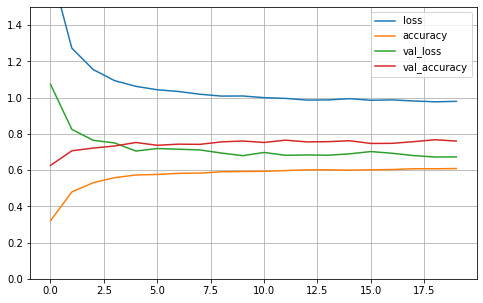

In [28]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_2do", tight_layout=False)
plt.show()

# EXPERIMENT 3

We create a `CNN` with 2 convolution/max pooling layers (**with drop out**) to work with our Fashion MNIST dataset. All layers will use the ReLU activation function.

This experiment evaluates the following for impact on model performance and process time:
* Image augmentation
* L2 regularization

## Data preparation
Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval.

Currently, our training images are stored in an array of shape (60000, 28, 28). Each image is represented by a 28x28 array of uint8 values in the range [0, 255]. 

We transform it into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1.

In [0]:
# # Data re-import and preparation
# from tensorflow.keras.datasets import fashion_mnist

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

In [0]:
# We transform it into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1. 
train_images = train_images.reshape((55000, 28, 28, 1))
val_images =val_images.reshape((5000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [0]:
# # Reshape images and scale
# train_images = train_images.reshape((60000, 28, 28, 1))
# train_images = train_images.astype('float32') / 255

# test_images = test_images.reshape((10000, 28, 28, 1))
# test_images = test_images.astype('float32') / 255

In [0]:
# Validation images
# val_images, train_images = train_images[:5000], train_images[5000:] 
# val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Model 3a: baseline model (no image augmentation or L2 regularization)
We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [0]:
model_3ado = models.Sequential()
model_3ado.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_3ado.add(layers.MaxPooling2D((2, 2)))
model_3ado.add(layers.Dropout(0.2))
model_3ado.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3ado.add(layers.MaxPooling2D((2, 2)))
model_3ado.add(layers.Dropout(0.2))
model_3ado.add(layers.Flatten())
model_3ado.add(layers.Dense(128, activation='relu'))
model_3ado.add(layers.Dense(10, activation='softmax'))

# starter code
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

In [0]:
model_3ado.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

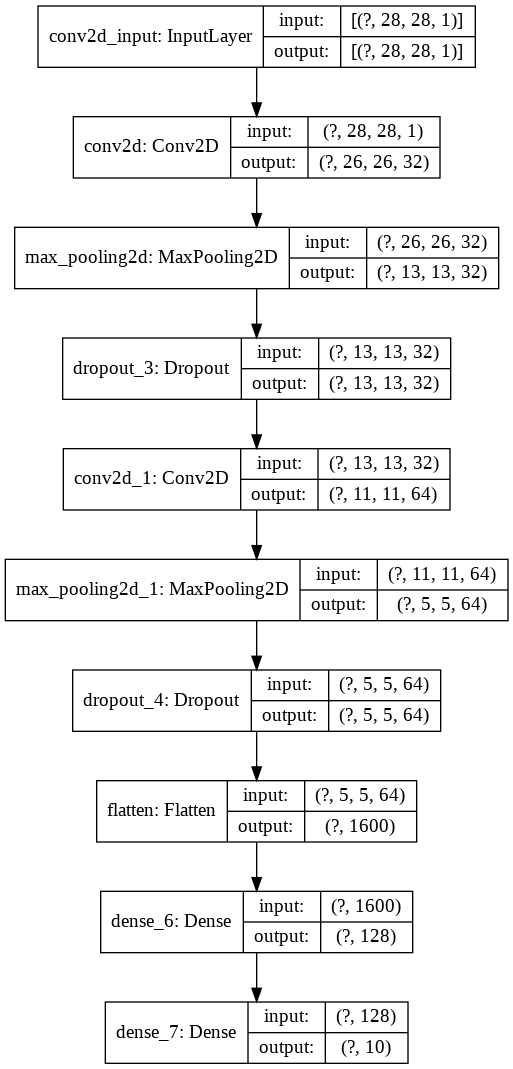

In [0]:
keras.utils.plot_model(model_3ado, show_shapes=True)

## Compile the model

In [0]:
model_3ado.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [33]:
train_rt = TrainRuntimeCallback()
history = model_3ado.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_3ado.h5'
model_path = os.path.join(save_dir, model_name)
model_3ado.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 0.5909 - accuracy: 0.7838 - val_loss: 0.4008 - val_accuracy: 0.8534
Epoch 2/20
550/550 [==============================] - 2s 3ms/step - loss: 0.3981 - accuracy: 0.8559 - val_loss: 0.3349 - val_accuracy: 0.8838
Epoch 3/20
550/550 [==============================] - 2s 3ms/step - loss: 0.3412 - accuracy: 0.8767 - val_loss: 0.2846 - val_accuracy: 0.8982
Epoch 4/20
550/550 [==============================] - 2s 3ms/step - loss: 0.3069 - accuracy: 0.8881 - val_loss: 0.2707 - val_accuracy: 0.9044
Epoch 5/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2856 - accuracy: 0.8951 - val_loss: 0.2525 - val_accuracy: 0.9090
Epoch 6/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2648 - accuracy: 0.9027 - val_loss: 0.2440 - val_accuracy: 0.9108
Epoch 7/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2510 - accuracy: 0.9079 - val_loss: 0.2606 - val_accuracy: 0.9006
Epoch 

In [34]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

43.51945

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [35]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_3ado.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.2540 - accuracy: 0.9109


In [36]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.802108

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.169447,0.936564,0.226331,0.9180
16,0.160688,0.939127,0.209297,0.9224
17,0.157761,0.940309,0.222035,0.9210
18,0.154297,0.941691,0.218343,0.9238
19,0.146241,0.944364,0.230351,0.9198


In [39]:
# Pull statistics 
results_df3a = history_df.iloc[-1:].copy()
results_df3a.insert(0,'model','CNN (2 layers DO)') # want the model name to appear first
results_df3a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3a

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers DO),0.146241,0.944364,0.230351,0.9198,43.51945,0.802108


In [0]:
# # Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = prev_results_df.append(results_df,ignore_index=True)
# results_df

## Plot the performance 

**Figure 3: Learning curves for Model 3a with dropout**

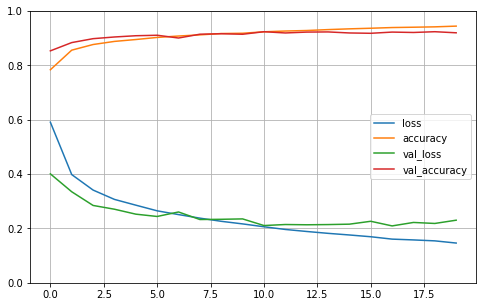

In [40]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3ado", tight_layout=False)
plt.show()

## Model 3b: baseline model with L2 regularization
We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes. L2 regularization is employed to evaluate whether it addresses overfitting.

In [0]:
model_3bdo = models.Sequential()
model_3bdo.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), 
                           input_shape=(28, 28, 1)))
model_3bdo.add(layers.MaxPooling2D((2, 2)))
model_3bdo.add(layers.Dropout(0.2))
model_3bdo.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3bdo.add(layers.MaxPooling2D((2, 2)))
model_3bdo.add(layers.Dropout(0.2))
model_3bdo.add(layers.Flatten())
model_3bdo.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3bdo.add(layers.Dense(10, activation='softmax'))

In [0]:
model_3bdo.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

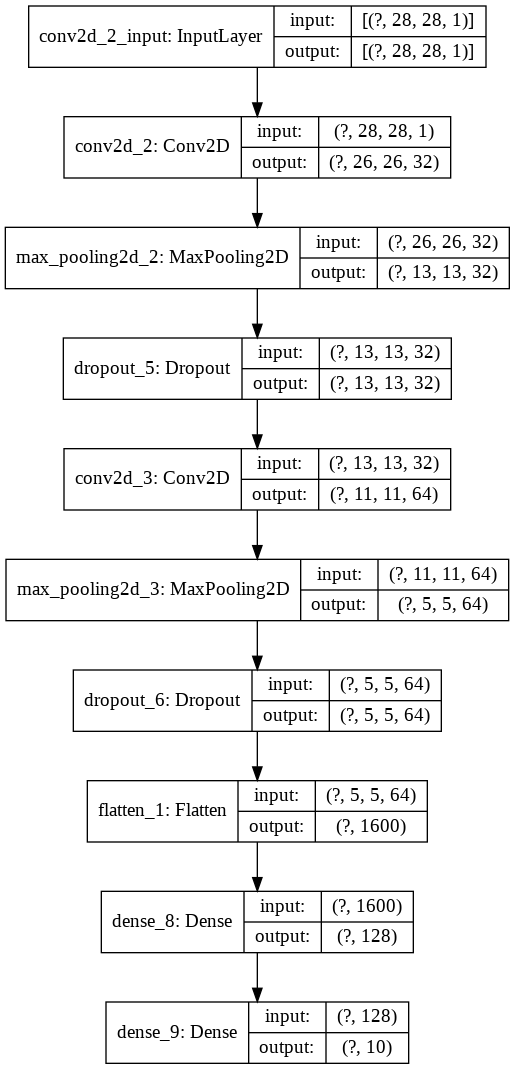

In [0]:
keras.utils.plot_model(model_3bdo, show_shapes=True)

## Compile the model

In [0]:
model_3bdo.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [43]:
train_rt = TrainRuntimeCallback()
history = model_3bdo.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_3bdo.h5'
model_path = os.path.join(save_dir, model_name)
model_3bdo.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 1.1878 - accuracy: 0.7424 - val_loss: 0.7420 - val_accuracy: 0.8232
Epoch 2/20
550/550 [==============================] - 2s 3ms/step - loss: 0.7629 - accuracy: 0.7954 - val_loss: 0.6962 - val_accuracy: 0.8348
Epoch 3/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7259 - accuracy: 0.8063 - val_loss: 0.6662 - val_accuracy: 0.8362
Epoch 4/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7075 - accuracy: 0.8097 - val_loss: 0.6403 - val_accuracy: 0.8424
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6910 - accuracy: 0.8140 - val_loss: 0.6493 - val_accuracy: 0.8376
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6734 - accuracy: 0.8203 - val_loss: 0.6122 - val_accuracy: 0.8454
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6664 - accuracy: 0.8204 - val_loss: 0.6340 - val_accuracy: 0.8474
Epoch 

In [44]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

40.009027

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [45]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_3bdo.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.5883 - accuracy: 0.8364


In [46]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.82611

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.607274,0.833545,0.561811,0.8568
16,0.606721,0.833236,0.563002,0.8506
17,0.597795,0.833782,0.572222,0.8484
18,0.596511,0.835309,0.544592,0.8600
19,0.593767,0.836236,0.556045,0.8532


In [49]:
# Pull statistics 
results_df3b = history_df.iloc[-1:].copy()
results_df3b.insert(0,'model','CNN (2 layers L2 DO)') # want the model name to appear first
results_df3b['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3b['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3b

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers L2 DO),0.593767,0.836236,0.556045,0.8532,40.009027,0.82611


## Plot the performance 

**Figure 4: Learning curves for Model 3b with dropout**

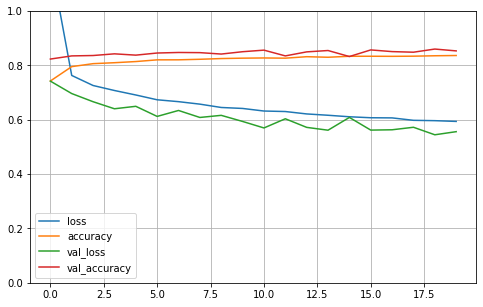

In [50]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3bdo", tight_layout=False)
plt.show()

## Model 3c: baseline model with image augmentation
We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes. Image augmentation (shifting, flipping, shearing, and zooming) is employed to generate data and potentially mitigate overfitting. 

In [0]:
model_3cdo = models.Sequential()
model_3cdo.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_3cdo.add(layers.MaxPooling2D((2, 2)))
model_3cdo.add(layers.Dropout(0.2))
model_3cdo.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3cdo.add(layers.MaxPooling2D((2, 2)))
model_3cdo.add(layers.Dropout(0.2))
model_3cdo.add(layers.Flatten())
model_3cdo.add(layers.Dense(128, activation='relu'))
model_3cdo.add(layers.Dense(10, activation='softmax'))

In [0]:
# Compile the model
model_3cdo.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [0]:
train_images.shape

(55000, 28, 28, 1)

In [0]:
# Create generators
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
            train_images, 
            train_labels, 
            batch_size=100)

val_generator = test_datagen.flow(
            val_images, 
            val_labels, 
            batch_size=100)

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
train_images.shape, val_images.shape

((55000, 28, 28, 1), (5000, 28, 28, 1))

In [0]:
(len(train_images) /100),(len(val_images) /100)

(550.0, 50.0)

In [0]:
# Image augmentation

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
x = train_images[0]
x = x.reshape((1,) + x.shape)
x.shape

(1, 28, 28, 1)

In [0]:
# # This is module with image preprocessing utilities
# from tensorflow.keras.preprocessing import image

# # The .flow() command below generates batches of randomly transformed images.
# # It will loop indefinitely, so we need to `break` the loop at some point!
# i = 0
# for batch in datagen.flow(x, batch_size=1):
#     plt.figure(i)
#     imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='binary')
#     i += 1
#     if i % 4 == 0:
#         break

# plt.show()

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow(
            train_images, 
            train_labels, 
            batch_size=100)

val_generator = test_datagen.flow(
            val_images, 
            val_labels, 
            batch_size=100)

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
steps_per_epoch = len(train_images) /100,
validation_steps = len(val_images) /100

In [56]:
train_rt = TrainRuntimeCallback()
history = model_3cdo.fit(
      train_generator,
      steps_per_epoch = len(train_images) /100,
      epochs= 20,
      callbacks=[train_rt],
      validation_data= val_generator, 
      validation_steps = len(val_images) /100)

# history = model_3c.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
#                     validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_3cdo_aug.h5'
model_path = os.path.join(save_dir, model_name)
model_3cdo.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 13s 24ms/step - loss: 1.8783 - accuracy: 0.3023 - val_loss: 1.4234 - val_accuracy: 0.4438
Epoch 2/20
550/550 [==============================] - 14s 25ms/step - loss: 1.5245 - accuracy: 0.4414 - val_loss: 1.1126 - val_accuracy: 0.6140
Epoch 3/20
550/550 [==============================] - 14s 25ms/step - loss: 1.3878 - accuracy: 0.4899 - val_loss: 0.9832 - val_accuracy: 0.6590
Epoch 4/20
550/550 [==============================] - 14s 25ms/step - loss: 1.3101 - accuracy: 0.5161 - val_loss: 0.9435 - val_accuracy: 0.6616
Epoch 5/20
550/550 [==============================] - 14s 25ms/step - loss: 1.2522 - accuracy: 0.5378 - val_loss: 0.8869 - val_accuracy: 0.6784
Epoch 6/20
550/550 [==============================] - 14s 25ms/step - loss: 1.2165 - accuracy: 0.5509 - val_loss: 0.8639 - val_accuracy: 0.7036
Epoch 7/20
550/550 [==============================] - 14s 25ms/step - loss: 1.1755 - accuracy: 0.5653 - val_loss: 0.8246 - val_accuracy:

In [57]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

274.081636

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [58]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_3cdo.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 172.3851 - accuracy: 0.3843


In [59]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.759575

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [60]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [61]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,1.025672,0.615764,0.723242,0.7318
16,1.012316,0.620309,0.702840,0.7456
17,1.006343,0.624200,0.699430,0.7316
18,0.996438,0.627527,0.697162,0.7428
19,0.986620,0.632764,0.713365,0.7226


In [62]:
# Pull statistics 
# Pull statistics 
results_df3c = history_df.iloc[-1:].copy()
results_df3c.insert(0,'model','CNN (2 layers aug DO)') # want the model name to appear first
results_df3c['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3c['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3c

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers aug DO),0.98662,0.632764,0.713365,0.7226,274.081636,0.759575


In [0]:
# Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = results_df.append(results_df3a,ignore_index=True)
# results_df = results_df.append(results_df3b,ignore_index=True)
# results_df

## Plot the performance 

**Figure 5: Learning curves for Model 3c with dropout**

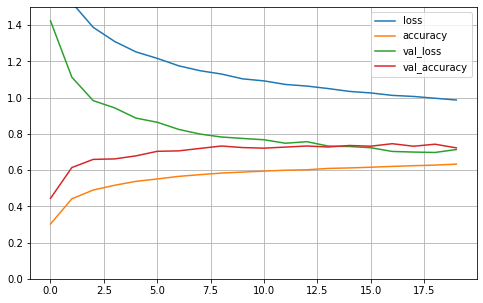

In [64]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3c_augdo", tight_layout=False)
plt.show()

# EXPERIMENT 4
We create a `CNN` with 3 convolution/max pooling layers (**with drop out**) to work with our Fashion MNIST dataset. The experiment compares performance using L2 regularization in the convolutional layers. Image augmentation is not employed.

## Model 4a: baseline CNN with 3 layers (no L2 regularization)

In [0]:
model_4ado = models.Sequential()
model_4ado.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_4ado.add(layers.MaxPooling2D((2, 2)))
model_4ado.add(layers.Dropout(0.2))
model_4ado.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4ado.add(layers.MaxPooling2D((2, 2)))
model_4ado.add(layers.Dropout(0.2))
model_4ado.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4ado.add(layers.Dropout(0.2))
model_4ado.add(layers.Flatten())
model_4ado.add(layers.Dense(64, activation='relu'))
model_4ado.add(layers.Dense(10, activation='softmax'))

In [0]:
model_4ado.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)         

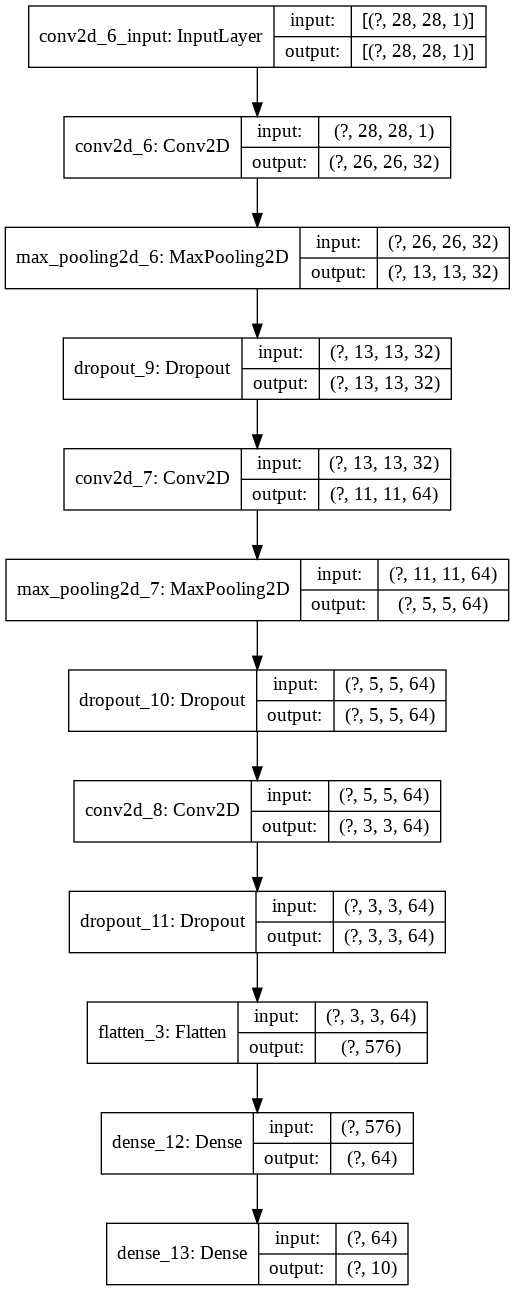

In [0]:
keras.utils.plot_model(model_4ado, show_shapes=True)

## Compile the model

In [0]:
model_4ado.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [67]:
train_rt = TrainRuntimeCallback()
history = model_4ado.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_4ado.h5'
model_path = os.path.join(save_dir, model_name)
model_4ado.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6897 - accuracy: 0.7399 - val_loss: 0.4274 - val_accuracy: 0.8460
Epoch 2/20
550/550 [==============================] - 2s 4ms/step - loss: 0.4305 - accuracy: 0.8429 - val_loss: 0.3584 - val_accuracy: 0.8710
Epoch 3/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3690 - accuracy: 0.8653 - val_loss: 0.3088 - val_accuracy: 0.8890
Epoch 4/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3388 - accuracy: 0.8745 - val_loss: 0.2786 - val_accuracy: 0.8980
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3155 - accuracy: 0.8831 - val_loss: 0.2731 - val_accuracy: 0.8962
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2993 - accuracy: 0.8894 - val_loss: 0.2692 - val_accuracy: 0.9006
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2864 - accuracy: 0.8927 - val_loss: 0.2464 - val_accuracy: 0.9108
Epoch 

In [68]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

41.460279

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [69]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_4ado.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.2424 - accuracy: 0.9106


In [70]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.794109

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [71]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.221353,0.916636,0.214229,0.9218
16,0.217287,0.918800,0.221239,0.9154
17,0.213589,0.919709,0.208089,0.9244
18,0.207445,0.921818,0.214433,0.9234
19,0.204254,0.922327,0.212962,0.9220


In [73]:
# Pull statistics 
# Pull statistics 
results_df4a = history_df.iloc[-1:].copy()
results_df4a.insert(0,'model','CNN (3 layers DO)') # want the model name to appear first
results_df4a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4a

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers DO),0.204254,0.922327,0.212962,0.922,41.460279,0.794109


In [0]:
# Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = results_df.append(results_df3a,ignore_index=True)
# results_df = results_df.append(results_df3b,ignore_index=True)
# results_df

## Plot the performance 

**Figure 6: Learning curves for Model 4a with dropout**

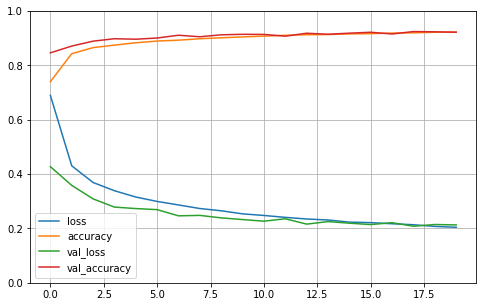

In [74]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4ado", tight_layout=False)
plt.show()

## Model 4b:  CNN with 3 layers + L2 regularization

In [0]:
model_4bdo = models.Sequential()
model_4bdo.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01),
                           input_shape=(28, 28, 1)))
model_4bdo.add(layers.MaxPooling2D((2, 2)))
model_4bdo.add(layers.Dropout(0.2))
model_4bdo.add(layers.Conv2D(64, (3, 3), activation='relu',  
                           kernel_regularizer=regularizers.l2(0.01)))
model_4bdo.add(layers.MaxPooling2D((2, 2)))
model_4bdo.add(layers.Dropout(0.2))
model_4bdo.add(layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
model_4bdo.add(layers.Dropout(0.2))
model_4bdo.add(layers.Flatten())
model_4bdo.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_4bdo.add(layers.Dense(10, activation='softmax'))

In [0]:
model_4bdo.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)         

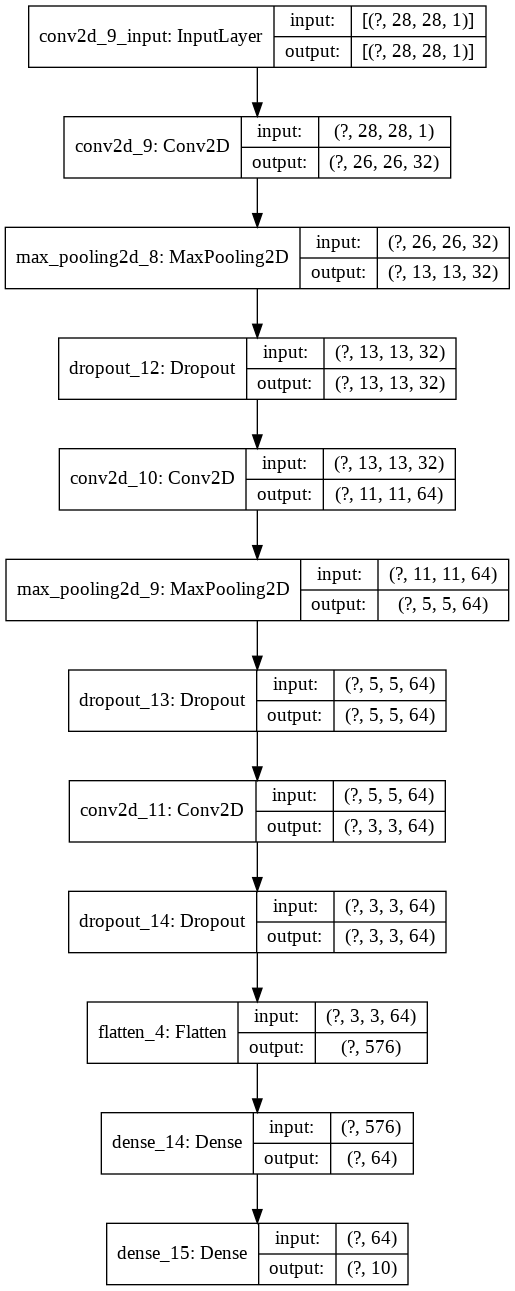

In [0]:
keras.utils.plot_model(model_4bdo, show_shapes=True)

## Compile the model

In [0]:
model_4bdo.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [77]:
train_rt = TrainRuntimeCallback()
history = model_4bdo.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_4bdo.h5'
model_path = os.path.join(save_dir, model_name)
model_4bdo.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 1.3313 - accuracy: 0.6980 - val_loss: 0.8739 - val_accuracy: 0.7870
Epoch 2/20
550/550 [==============================] - 2s 4ms/step - loss: 0.8616 - accuracy: 0.7693 - val_loss: 0.7634 - val_accuracy: 0.8030
Epoch 3/20
550/550 [==============================] - 2s 4ms/step - loss: 0.8049 - accuracy: 0.7810 - val_loss: 0.7336 - val_accuracy: 0.8096
Epoch 4/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7789 - accuracy: 0.7906 - val_loss: 0.7281 - val_accuracy: 0.8264
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7710 - accuracy: 0.7915 - val_loss: 0.6977 - val_accuracy: 0.8268
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7569 - accuracy: 0.7961 - val_loss: 0.6940 - val_accuracy: 0.8302
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7463 - accuracy: 0.7991 - val_loss: 0.7009 - val_accuracy: 0.8194
Epoch 

In [78]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

42.996661

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [79]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_4bdo.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.6640 - accuracy: 0.8192


In [80]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.00616

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [81]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [82]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.684128,0.816455,0.652140,0.8396
16,0.683546,0.817291,0.631336,0.8466
17,0.675915,0.818800,0.615065,0.8540
18,0.676843,0.819273,0.618677,0.8484
19,0.674064,0.819782,0.629076,0.8384


In [83]:
# Pull statistics 
# Pull statistics 
results_df4b = history_df.iloc[-1:].copy()
results_df4b.insert(0,'model','CNN (3 layers L2 DO)') # want the model name to appear first
results_df4b['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4b['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4b

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers L2 DO),0.674064,0.819782,0.629076,0.8384,42.996661,1.00616


In [0]:
# Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = results_df.append(results_df3a,ignore_index=True)
# results_df = results_df.append(results_df3b,ignore_index=True)
# results_df

## Plot the performance 

**Figure 7: Learning curves for Model 4b with dropout**

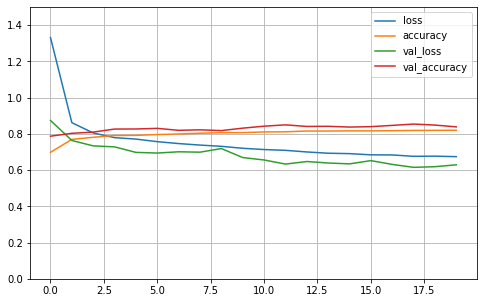

In [84]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4bdo", tight_layout=False)
plt.show()

# Compile all results into a DataFrame

In [85]:
# # Add the new data to results_df:
# results_df2
# results_df3a
# results_df3b
# results_df3c
# results_df4a
# results_df4b

results_df_do=results_df_do.append(results_df2,ignore_index=True)
results_df_do=results_df_do.append(results_df3a,ignore_index=True)
results_df_do=results_df_do.append(results_df3b,ignore_index=True)
results_df_do=results_df_do.append(results_df3c,ignore_index=True)
results_df_do=results_df_do.append(results_df4a,ignore_index=True)
results_df_do=results_df_do.append(results_df4b,ignore_index=True)

results_df_do

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers DO),1.039818,0.627073,0.687543,0.8116,25.842328,0.654728
1,DNN (3 layers DO),0.979232,0.608491,0.672728,0.7602,25.392829,0.637817
2,CNN (2 layers DO),0.146241,0.944364,0.230351,0.9198,43.519450,0.802108
3,CNN (2 layers L2 DO),0.593767,0.836236,0.556045,0.8532,40.009027,0.826110
4,CNN (2 layers aug DO),0.986620,0.632764,0.713365,0.7226,274.081636,0.759575
5,CNN (3 layers DO),0.204254,0.922327,0.212962,0.9220,41.460279,0.794109
6,CNN (3 layers L2 DO),0.674064,0.819782,0.629076,0.8384,42.996661,1.006160


In [87]:
# Combine with previous results
prev_results_df = pd.read_pickle('results/results_table.pkl')
results_df_new = prev_results_df.append(results_df_do,ignore_index=True)
results_df_new

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.445179,0.845818,0.446092,0.8482,33.456518,0.959970
1,DNN (3 layers),0.393804,0.862691,0.418285,0.8578,33.351694,0.907039
2,CNN (2 layers),0.062694,0.977255,0.342600,0.9102,46.694116,1.092569
3,CNN (2 layers L2),0.520660,0.857909,0.493949,0.8732,43.898222,1.081623
4,CNN (2 layers aug),1.025814,0.621236,0.765337,0.7222,436.083312,1.024631
5,CNN (3 layers),0.082464,0.969909,0.314664,0.9150,44.815734,1.112644
6,CNN (3 layers L2),0.589668,0.846236,0.581835,0.8528,48.277778,1.097991
7,DNN (2 layers DO),1.039818,0.627073,0.687543,0.8116,25.842328,0.654728
8,DNN (3 layers DO),0.979232,0.608491,0.672728,0.7602,25.392829,0.637817
9,CNN (2 layers DO),0.146241,0.944364,0.230351,0.9198,43.519450,0.802108
